In [4]:
# Importation des librairies devant nous aider pour le projet
import glob
import cv2
import numpy as np
import os
%matplotlib inline
from matplotlib import pyplot as plt
import natsort
import random
from collections import OrderedDict
import pickle
!pip install lshashpy3
!python -c "import lshashpy3 as lshash; print(lshash.__version__);"
from lshashpy3 import LSHash
from google.colab.patches import cv2_imshow
import shutil
from numpy.ma import fix_invalid
from tqdm import tqdm
import json 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for lshashpy3: filename=lshashpy3-0.0.8-py3-none-any.whl size=8903 sha256=f1e5d117943e22d0c290672474dc84fa0c524ec8b9f26b6f49848d5f1cc0b1dc
  Stored in directory: /root/.cache/pip/wheels/32/9b/ae/27f94ba2cd85b1cd5af645fa78f90b703c9e1fb9e2b55a04e0
Successfully built lshashpy3
0.0.8


In [ ]:
# Télécharge notre dataset à partir de du drive en utilisant le lien de téléchargement et le dataset est public
!gdown --id 1Ui6MDCkTjRVgw2A2l4QB--JJRVfxsS6q
# dézipper le fichier
!unzip tobacco_examples.zip
# Supprimer le fichier zippé
!rm -r /content/tobacco_examples.zip

# Cette fonction permet de lire nos données images et nos frames, elle va retourner:


1.   classe_vrai qui représente le nom de chaque frame
2.   label qui représente le nom de chacun de nos images 
1.   jpg_names représente nos données images donc nous allons utiliser pour le calcul de nos descripteurs SIFT
2.   mp4_names représente le nom contenant le chemein d'accès à nos différentes vidéos


In [6]:
#Fonction permettant de lire notre dataset, labels
def images_numpy_images_videos(chemin):
  jpg_names = []
  mp4_names = []
  label = []
  classe_vrai = []
  for dirname, _, filenames in os.walk(chemin):
    for filename in filenames:
      if os.path.join(dirname, filename)[-3:] != 'jpg':
        if filename != '.DS_Store':
          name3, name4 = filename.split('.')
          name5, name6 = name3.split('-')
          if len(name5) == 1:
            name6 = '000'+str(name5)
          else:
            name6 = '00'+str(name5)
          classe_vrai.append(name6)
          mp4_names.append(os.path.join(dirname, filename))
          # print(filename)

      else:
        # print(filename)
        name1, name2 = filename.split('.')
        label.append(name1)
        # print(nom_doc)cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        image = cv2.imread(os.path.join(dirname, filename))
        # print(filename)

        jpg_names.append(image)
  return classe_vrai, label, np.array(jpg_names), mp4_names

classe_vrai, label, jpg_names, mp4_names = images_numpy_images_videos('/content/tobacco_examples')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


# Afficher quelques images aléatoires de notre dataset 

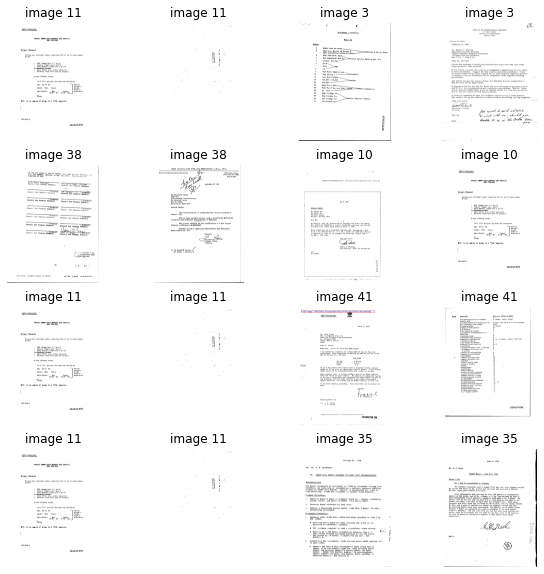

In [7]:
plt.figure(figsize=(10, 10))
for k, i in np.ndenumerate(np.random.randint(jpg_names.shape[0], size=8)):
    ax = plt.subplot(4, 4, 2 * k[0] + 1)
    plt.imshow(jpg_names[i], cmap='gray')
    plt.title('image {}'.format(i))
    plt.axis("off")
    x = plt.subplot(4, 4, 2 * k[0] + 2)
    plt.imshow(jpg_names[i+1], cmap='gray')
    plt.title('image {}'.format(i))
    plt.axis("off")

# Calcul des descripteurs de nos différentes images devant ètre indexés


1.   Čalcul des points d'intérèts et descripteurs de chacun des images de notre jeu de données
2.   Comptage des valeurs non-nulles de vos différents vecteurs de chaque descripteur
2.   Reconstruction du descripteur en partant des vecteurs les plus pertinants c'est-à-dire qui ont un très grand nombre de valeurs non-nulles
2.   Sélection de quelques vecteurs en tenant compte du seuil


In [8]:
def calcul_descripteur_sift(listImage, seuil):
  # Creation de l'objet sift
  sift = cv2.SIFT_create()
  # Liste contenant les descripteurs
  liste_descripteur = []
  liste_key_point = []
  listeClasse = []
  # Parcourir les images de notre jeu de données d'entrainement
  for i, im in enumerate(listImage):
    # print(im.shape)
    
    # break
    # dim = (512, 512)
    # resize image
    # im = cv2.resize(im, dim, interpolation = cv2.INTER_AREA)
    # cv2_imshow(im)
    img1 = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    # Détection des points d'intérèts et des descripteurs de points d'intérèts 
    keypoint, descripteur = sift.detectAndCompute(img1,None)
    # print(descripteur.shape)
    # initialisation de la liste devant contenir les vecteur
    liste = []
    # Initialisation du dictionnaire devant contenir les références (indices) de descripteurs et le nombre de valeurs non-nulles de ce vecteur
    dic = {}
    for i, a in enumerate(descripteur):
      # Mets le nombre de valeurs non-nulles du vecteur du descripteur à un indice précis
      dic[i] = np.count_nonzero(a)
    # trier dans l'ordre de valeur décroissant
    dic = dict(sorted(dic.items(), key=lambda item: item[1], reverse = True))
    # print(dic)
    # Construire un nouveau dictionnaire contenant les seuils premiers éléments de notre dictionnaire
    l_key = list(dic.keys())[:seuil]
    # print(l_key)
    for cle in l_key:
      # print(cle)
      liste.append(descripteur[cle])
    # Reconstruction du descripteur
    des = np.array(liste, dtype = 'float32')
    # print(des)
    liste_descripteur.append(des)

  return np.array(liste_descripteur)

descripteur = calcul_descripteur_sift(jpg_names, seuil =200)

In [9]:
descripteur[0].shape

(200, 128)

In [10]:
# Crée un dossier vide devant contenir les images provenant des frames de nos vidéos
!mkdir dossier1

# Fonction permettant de créer une image par fichier vidéo

In [11]:
# Fonction de création de fichier image 
def generate_une_image_par_frame(mp4_names):
  for name in mp4_names:
    a = name.split('/')
    c, d = a[len(a)-1].split('.')
    cap= cv2.VideoCapture(name)
    i = 0
    while(cap.isOpened()):
      ret, frame = cap.read()
      if ret == True and i == 0:
        # Sauvegarde chaque image dans le fichier dossier1
        cv2.imwrite('/content/dossier1/'+c+'.jpg',frame)
      if ret == False:
        break
      i += 1
    cap.release()
    cv2.destroyAllWindows()

generate_une_image_par_frame(mp4_names)

# Fonction permettant de créer une liste d'images devant servir pour la requète ainsi que leur noms

In [12]:
# Fonction permettant de lire les images dans dossier1 
def read_image_test(chemin):
  image_names = []
  label_frame = []
  for dirname, _, filenames in os.walk(chemin):
    for filename in filenames:
      if os.path.join(dirname, filename)[-3:] == 'jpg':
          image = cv2.imread(os.path.join(dirname, filename))
          a, b = filename.split('.')
          # Met le nom du fichier sans extension dans une liste
          label_frame.append(a)
          # Sauve chaque image dans une liste
          image_names.append(image)
  # retourne les fichier devant servir pour la requète et leur nom
  return np.array(image_names), label_frame

image_test, fichier_name_test = read_image_test('/content/dossier1')

In [13]:
fichier_name_test[0]

'22-BL'

# Fonction permettant de créer la table de hachage de notre jeu de données

In [14]:
def table_hash(descripteurs, label):
  # Initialisation de l'objet LSH avec comme paramètre le nombre de bits 6 et la dimension
  # correspondant à la dimension de nos descrpiteurs
  lsh = LSHash(6, 128)
  i=0
  essai = {}
  for element in descripteurs:
    for vector in element:
      lsh.index(vector, extra_data=label[i])
      
    i+=1

  return lsh
# Appel de la fonction avec comme paramètre la liste des descripteurs et leurs labels
table_h = table_hash(descripteur, label)

In [15]:
# Création d'un fichier pickle pour sauver la table de hachage 
# pickle permet de que l'objet puisse garder son type dans le fichier texte
# Ce fichier devra nous aider lors du déploiement sur streamlit
with open("lsh_table_optimal.pickle", "wb") as file:
    pickle.dump(table_h, file, pickle.HIGHEST_PROTOCOL)

In [16]:
# lecture de notre fichier pickle
with open("lsh_table_optimal.pickle", "rb") as file:
    table_has = pickle.load(file)

In [17]:
# Calcul des descripteurs de nos fichier images provenant des frames de nos vidéos pour l'évaluation de nos requètes
descripteur_test = calcul_descripteur_sift(image_test, seuil =200)

In [34]:
# Requète teste sur le premier élément de nos fichiers images provent de la frame de nos différentes vidéos
def afficher_resulta_une_frame(descripteur_test, table_has):
  finalDecompt = {}
  # Permet d'observer le temps de traitement restant
  with tqdm(total = len(descripteur_test), desc = 'charement', bar_format="{l_bar}{l_bar} [time left: {remaining}]") as pbar:
    for element in descripteur_test:
      # Indexation en utilisant chaque vecteur de nos descripteurs grace à l'utilisation euclidienne
      nn = table_h.query(element, num_results=1, distance_func="euclidean")
      for ((vec,extra_data),distance) in nn:
        if extra_data not in finalDecompt:
          finalDecompt[extra_data] = 1
        else:
          finalDecompt[extra_data] +=1
      pbar.update(1)
    # finalDecompt = dict(sorted(finalDecompt.items(), key=lambda item: item[1], reverse = True))
  return finalDecompt

h = afficher_resulta_une_frame(descripteur_test[0], table_h)
print('\n')
print('Le résultat pour le cas du fichier '+str(fichier_name_test[0]))
print('\n')
print(h)

charement: 100%|charement: 100%| [time left: 00:00]



Le résultat pour le cas du fichier 22-BL


{'0007': 9, '0013': 13, '0039': 7, '0017': 1, '0053': 2, '0047': 1, '0046': 3, '0056': 5, '0035': 2, '0002': 26, '0027': 3, '0041': 5, '0045': 3, '0026': 5, '0052': 2, '0033': 9, '0030': 7, '0025': 4, '0016': 3, '0021': 3, '0048': 3, '0049': 10, '0037': 5, '0038': 1, '0034': 4, '0008': 17, '0029': 2, '0032': 5, '0055': 4, '0044': 3, '0057': 3, '0015': 4, '0036': 4, '0004': 2, '0024': 5, '0031': 2, '0010': 1, '0022': 3, '0020': 4, '0028': 1, '0042': 1, '0006': 2, '0043': 1}


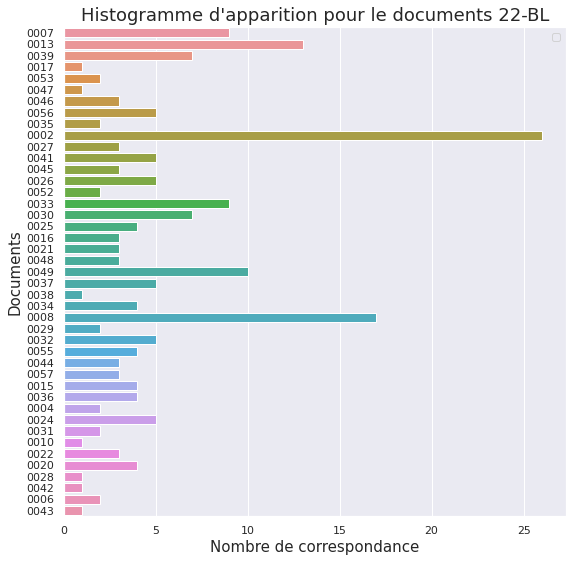

In [19]:
# Affiche de l'histogramme de la requète pour un document donné plus haut
import seaborn as sns
keys = [cle for cle in h]
vals = [int(h[cle]) for cle in h]
sns.set()
plt.figure(figsize = (9,9))
sns.barplot(x=vals, y=keys)
plt.title("Histogramme d'apparition pour le documents "+str(fichier_name_test[0]), fontsize = 18)
plt.ylabel("Documents", fontsize = 15)
plt.xlabel("Nombre de correspondance", fontsize = 15)
plt.savefig("Fréquence d'apparition des documents")
plt.legend()
plt.show()

# Requète pour les données images de tests afin d'évaluer notre modèle

In [20]:
def afficher_resulta_tout_frame(descripteur_test, table_has, label_frame):
  finalDecompt = {}
  with tqdm(total = len(descripteur_test), desc = 'charement', bar_format="{l_bar}{l_bar} [time left: {remaining}]") as pbar:
    for i, des in enumerate(descripteur_test):
      dict_frame = {}
      for element in des:
        nn = table_h.query(element, num_results=1, distance_func="cosine")
        for ((vec,extra_data),distance) in nn:
          if extra_data not in dict_frame:
            dict_frame[extra_data] = 1
          else:
            dict_frame[extra_data] +=1
      dic = dict(sorted(dict_frame.items(), key=lambda item: item[1], reverse = True))
      finalDecompt[label_frame[i]] = dic
      pbar.update(1)
  return finalDecompt

model = afficher_resulta_tout_frame(descripteur_test, table_h, fichier_name_test)

charement: 100%|charement: 100%| [time left: 00:00]


In [21]:
def label_ordonne(mp4_names):
  label = []
  for name in mp4_names:
    a = name.split('/')
    c, d = a[len(a)-1].split('.')
    label.append(c)
  return label

nom_frame = label_ordonne(mp4_names)

# Fonction permettant d'évaluer notre modèle obtenu par le calcul du rappel

In [22]:
# from itertools import islice

def evaluation_indexation(model, classe_vrai, nom_frame, k):
  i = 0
  som = 0
  for name in nom_frame:
    # print(name)
    # Prendre les k premiers éléments du dictionnaire model
    l_key = list(model[name].keys())[:k]
    # Si le kième élément est dans la liste 
    # Incrémenter le taux
    if classe_vrai[i] in l_key:
      som += 1
    i += 1
    # print(som)
  return som/len(model) * 100

In [33]:
# Appel de la fonction de rappel
rappel = evaluation_indexation(model, classe_vrai, nom_frame, k=1)
print("Le rappel de notre model d'indexation est de: "+str(rappel)+'%')

Le rappel de notre model d'indexation est de: 84.05797101449275%


In [24]:
# Création de notre fichier json pour sauver notre model
# json = json.dumps(model, indent = len(model))
with open("/content/indexation_optimise.json", "w") as outfile:
    json.dump(model, outfile)